In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

pd.options.display.float_format = '{:.2f}'.format

from statsmodels.graphics.tsaplots import plot_acf
from model_SARIMA import *
from model_naiv import *
from test_mean import *
from test_correlation import *
from time_series import *
from cross_validation import *


warnings.filterwarnings("ignore")

Datensatz lesen

In [50]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

1 Store wählen

In [51]:
# Filtern nach Store
store_number = 43
store = df[df['store'] == store_number].copy()

# Datum als Index setzen
store.set_index('date', inplace=True)

# Spalte Weekly_Sales extrahieren
sales = store['weekly_sales']
sales = sales.asfreq('W-FRI')

Zeitreihe plotten

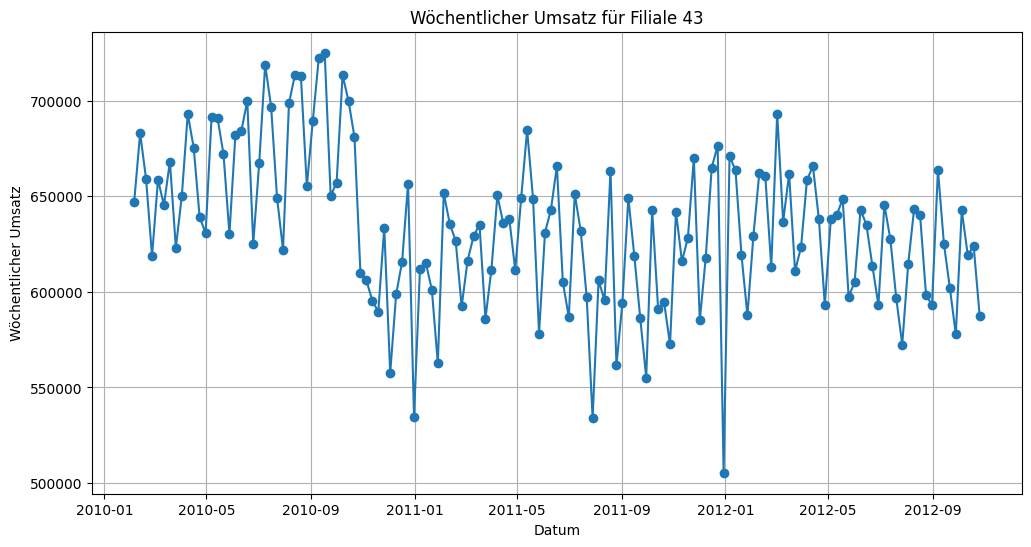

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Wöchentlicher Umsatz für Filiale {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.grid(True)
plt.show()

Seasonal

In [53]:
#seasonal_plot(sales)
#seasonal_subseries_plot(sales)
#acf_plot(sales)
#lag_plot(sales)
#decompose(sales)

Modell wählen

In [54]:
model_type = 'SARIMA'
#model_type = 'Naive'
#model_type = 'Additive'

Residuen und Fitted Values berechnen

In [55]:
if model_type == 'Naive':
    resid, fitted_values = build_naive_model(sales)

if model_type == 'Additive':
    resid, fitted_values = build_naive_additive(sales, sample = 'IS')
    resid_oos, fitted_values_oos = build_naive_additive(sales, sample = 'OOS')

if model_type == 'SARIMA':
    sarima_params  = optimal_orders_70_new.get(str(store_number))
    order = tuple(sarima_params["order"])
    seasonal_order = tuple(sarima_params["seasonal_order"])

    sarima_model, split, y_test = build_SARIMA(sales, order = order, seasonal_order = seasonal_order)


    resid = sarima_model.resid.iloc[1:]
    fitted_values = sarima_model.fittedvalues.iloc[1:]
    forecast = sarima_model.get_forecast(steps=43)
    forecast = forecast.predicted_mean
    sarima_model.summary()


print(len(y_test))

44


Plot

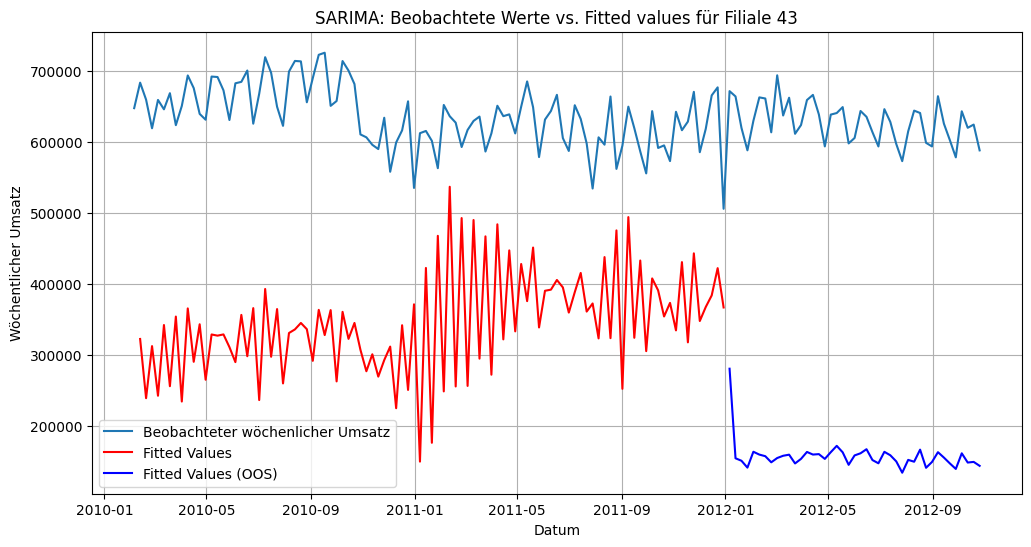

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachteter wöchenlicher Umsatz')
plt.plot(fitted_values, color='red', label='Fitted Values')
plt.plot(forecast, color='blue', label='Fitted Values (OOS)')
plt.title('SARIMA: Beobachtete Werte vs. Fitted values für Filiale {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.legend()
plt.grid(True)
plt.show()


In [57]:
pd.set_option('display.max_rows', None)
non_nan_count = resid.count()
print(non_nan_count)
print(len(resid))

99
99


Korrelations Tests

Box Pierce Test: 0.0000
Ljung Box Test: 0.0000
Monti Test: 0.0000
Fisher Test: 0.0000
Fisher Test: 0.0000
Pena Rodriguez (m=29, N=1000): 0.0010
Breusch Godfrey: 0.0001
Run Test: 0.0993
Durbin Watson: 0.1905


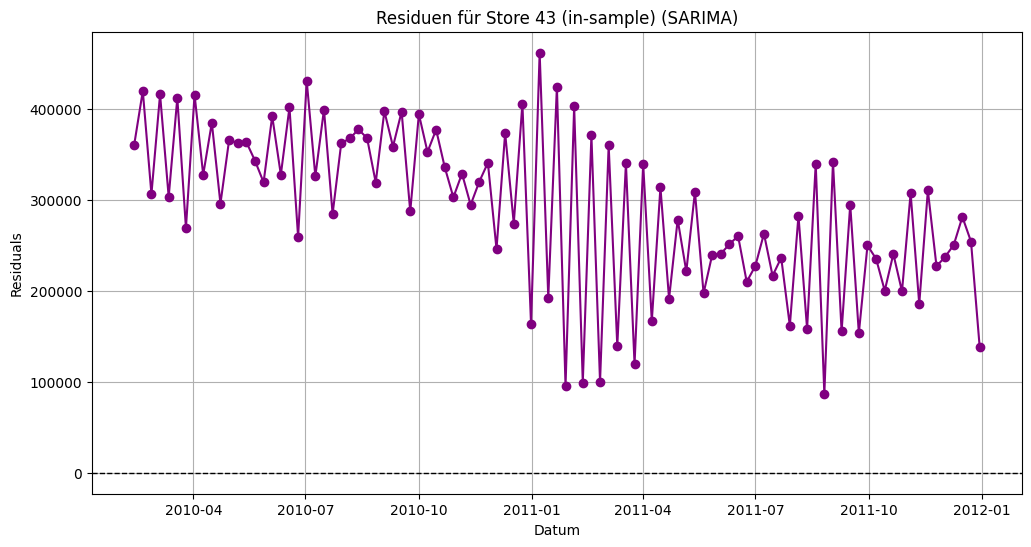

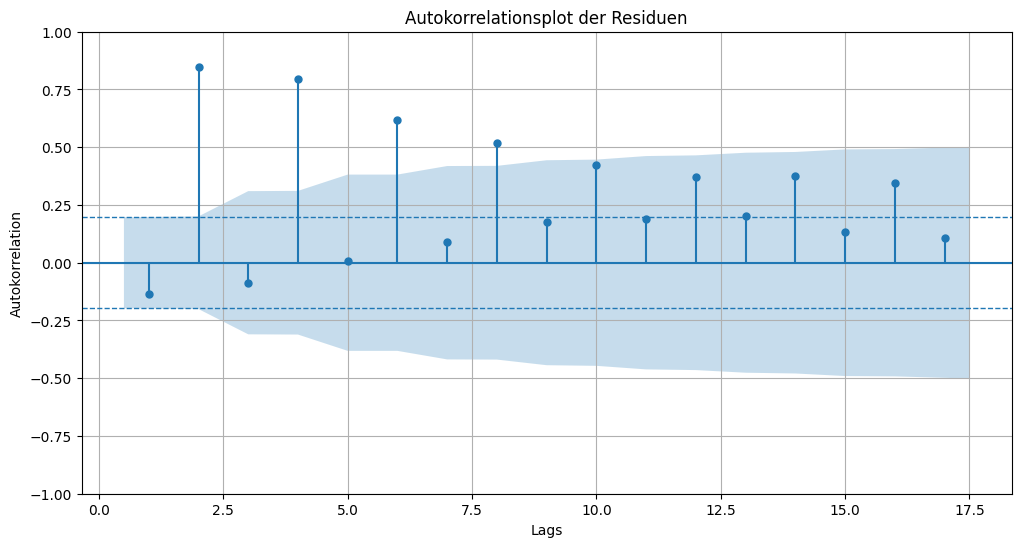

In [58]:
box_pierce_test(residuals = resid, store_num = store_number, model = model_type, lags = 17)
ljung_box_test(residuals = resid, store_num = store_number, model = model_type, lags = 17)
monti_test(residuals = resid, store_num = store_number, model = model_type, m = 17)
fisher_test(residuals = resid, store_num = store_number, model = model_type, version = "acf", m = 17)
fisher_test(residuals = resid, store_num = store_number, model = model_type, version = "pacf", m = 17)
pena_rodriguez_test_mc(residuals = resid)


if model_type == 'SARIMA':
    breusch_godfrey_test(model = sarima_model, lags = 17)
if model_type == 'Naive':
    breusch_godfrey_test_naive(sales, lags = 5)

run_test(residuals = resid)
durbin_watson_test(residuals = resid)

#Residuen Plot
plt.figure(figsize=(12, 6))
plt.plot(resid, marker='o', linestyle='-', color='purple')
plt.title('Residuen für Store {} (in-sample) ({})'.format(store_number, model_type))
plt.xlabel('Datum')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

#ACF Plot
acf_resid_plot(resid, lags = 17, print_results = True)



Mittelwert Tests

In [59]:
print(f"Mittelwert der Residuen: {resid.mean():.4f}")


t_test(resid)
wilcoxon_test(resid)
binomial_test(resid)
kolmogorov_test(resid)



Mittelwert der Residuen: 291069.4493
T-Test: 0.0000
Wilcoxon Test: 0.0000
Binomial Test: 0.0000
Kolmogorov Test: 0.0000


(0.8896477491860884, 3.667128661315475e-95)

SMAPE

In [60]:
numerator = np.abs(fitted_values - sales.iloc[1:])
denominator = (np.abs(fitted_values) + np.abs(sales.iloc[1:])) / 2
smape = np.where(denominator == 0, 0, numerator / denominator)
smape = np.mean(smape) * 100
print(f"SMAPE: {smape:.2f}%")

SMAPE: nan%


Kreuz Validierung

In [61]:
#if model_type == 'SARIMA':
#    cv_df, train_size = cross_validation_SARIMA(sales, order = order, seasonal_order = seasonal_order)
#if model_type == 'Naive':
#    cv_df = cross_validation_naive(sales)
#if model_type == 'Additive':
#    residuals, fitted_series = build_naive_additive(sales, sample = 'OOS')



Korrelations Tests

Box Pierce Test: 0.1445
Ljung Box Test: 0.0860
Monti Test: 0.0000
Fisher Test: 0.5405
Fisher Test: 0.0606
Pena Rodriguez (m=29, N=1000): 0.1828
Breusch Godfrey: 0.0023
Run Test: 0.9275
Durbin Watson: 0.0053


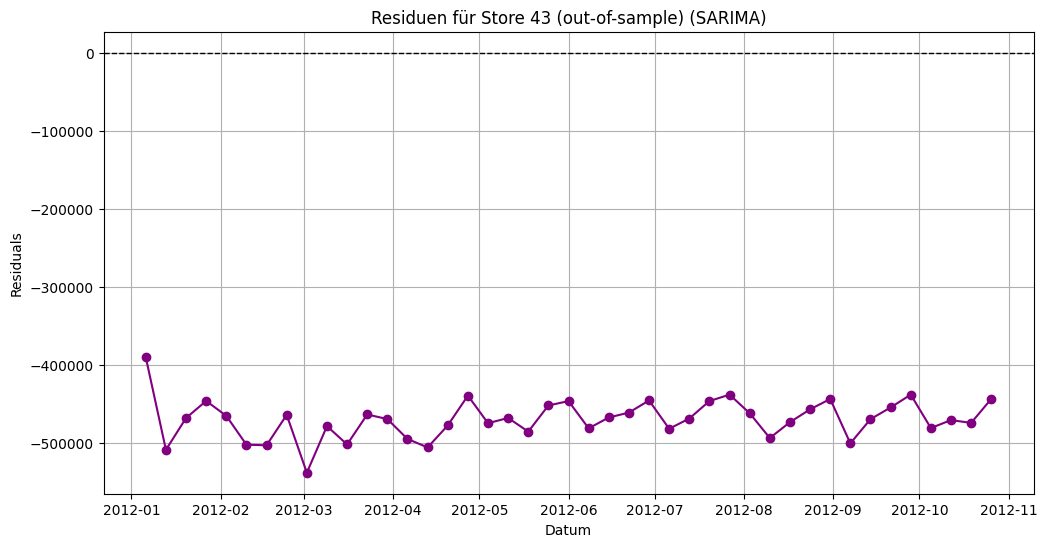

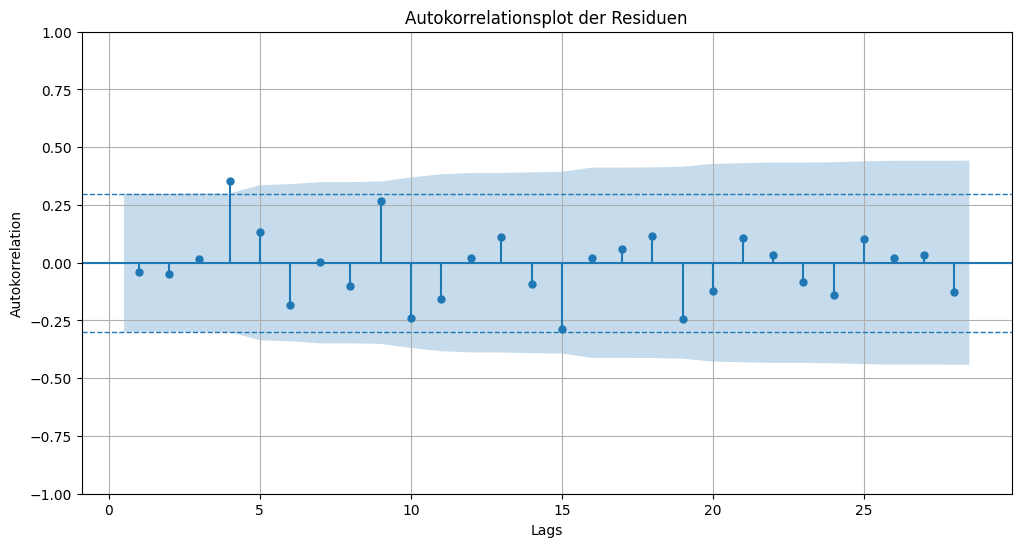

In [62]:
errors = forecast - sales.iloc[split:]

#errors = cv_df['error']
#print(len(errors))


box_pierce_test(residuals = errors, store_num = store_number, model = model_type, lags = 29)
ljung_box_test(residuals = errors, store_num = store_number, model = model_type, lags = 29)
monti_test(residuals = errors, store_num = store_number, model = model_type, m = 21)
fisher_test(residuals = errors, store_num = store_number, model = model_type, version = "acf", m = 21)
fisher_test(residuals = errors, store_num = store_number, model = model_type, version = "pacf", m = 21)
pena_rodriguez_test_mc(residuals = errors)


if model_type == 'SARIMA':
    breusch_godfrey_test(model = sarima_model, lags = 29) #TODO: Gleich wie in-sample?
if model_type == 'Naive':
    breusch_godfrey_test_naive(sales, lags = 5)


run_test(residuals = errors)

durbin_watson_test(residuals = errors)

#Residuen Plot
plt.figure(figsize=(12, 6))
plt.plot(errors, marker='o', linestyle='-', color='purple')
plt.title('Residuen für Store {} (out-of-sample) ({})'.format(store_number, model_type))
plt.xlabel('Datum')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()


acf_resid_plot(residuals = errors, lags = 28, print_results = True)


Mittelwert Tests

In [63]:
print(f'Mittelwert der Errors: {errors.mean()}')

t_test(errors)
wilcoxon_test(errors)
binomial_test(errors)
kolmogorov_test(errors)



Mittelwert der Errors: -470071.8846167604
T-Test: 0.0000
Wilcoxon Test: 0.0000
Binomial Test: 0.0000
Kolmogorov Test: 0.0000


(1.0, 0.0)

SMAPE

In [64]:
actual_values = cv_df['actual']
forecast_values = cv_df['forecast']

numerator = np.abs(forecast_values - actual_values)
denominator = (np.abs(forecast_values) + np.abs(actual_values)) / 2
smape = np.where(denominator == 0, 0, numerator / denominator)
smape = np.mean(smape) * 100
print(f"SMAPE: {smape:.2f}%")

NameError: name 'cv_df' is not defined